# 카메라 스티커앱 만들기 첫걸음

### 어떻게 만들까? 사진 준비하기

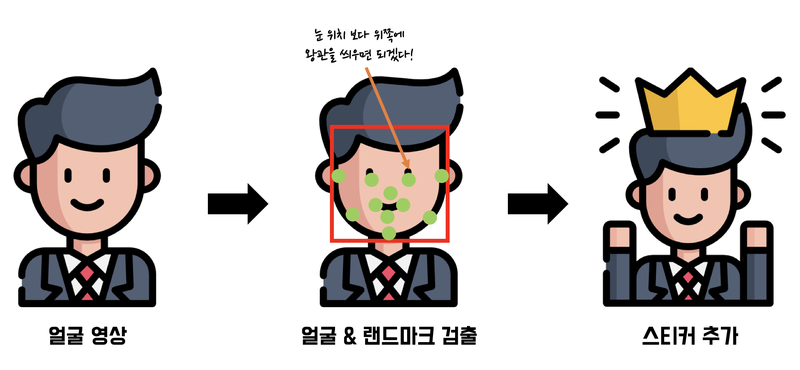

스티커를 세밀하고 자연스럽게 적용하기 위해서 눈, 코, 입, 귀와 같은 얼굴 각각의 위치를 아는 것이 중요하다. 이 위치들을 찾아내는 기술을 랜드마크 landmark 또는 조정 alignment 이라고 한다. 조금 더 큰 범위로는 keypoint detection 이라고 부르고 있다. 대부분의 face landmark 데이터셋은 눈, 코, 입과 턱을 포함하고 있다. 얼굴의 랜드마크를 찾아냈다면 머리의 위치를 예상하는 것은 쉽다. 눈과 코의 위치로부터 위로 떨어져 있는 정도를 데이터로부터 유추할 수 있다.

따라서 우리는,

1. 얼굴이 포함된 사진을 준비하고
3. 사진으로부터 얼굴 영역 face landmark 를 찾아냅니다. (landmark를 찾기 위해서는 얼굴의 bounding box를 먼저 찾아야합니다.)
3. 찾아진 영역으로 부터 머리에 왕관 스티커를 붙여넣겠습니다.

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

In [25]:
print(cv2.__version__)

4.6.0


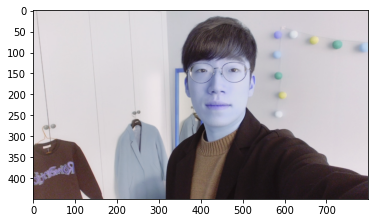

In [27]:
my_image_path = "/content/drive/MyDrive/crown_data/image.png"
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

opencv의 특징 떄문에 얼굴 색이 파랗게 보인다. matplotlib.dlib 등의 이미지 라이브러리는 모두 이미지 채널을 RGB(빨강, 녹색, 파랑) 순으로 사용한다. 그런데 opencv는 예외적으로 BGR(파랑, 녹색, 빨강)을 사용한다. 그래서 원본 사진에서 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력된다.

그래서 이를 보정해보자.

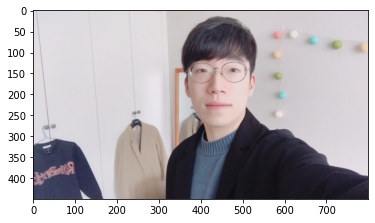

In [28]:
# plt.inshow 이전에 RGB 이미지로 바꾸는 것을 잊지 말자

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

#### cv2.imread('img.png'.0) 무슨 의미일까?

문서에 따르면 이미지 읽기는 flag는 다음 3가지가 있다. 순서대로 1, 0, -1의 값을 갖는다.

cv2.IMREAD_COLOR: 이미지 파일의 Color로 읽어드립니다. 투명한 부분은 무시되며, Default값이다.

cv2.IMREAD_GRAYSCALE : 이미지를 Grayscale로 읽어 드린다. 실제 이미지 처리시 중간단계로 많이 사용한다.

cv2.IMREAD_UNCHANGED : 이미지 파일을 alpha channel까지 포함하여 읽어 드린다.

cv2.imread('img.png'.0)이라고 호출했다면 이미지를 Grayscale로 읽어 드리겠다는 뜻이다. 실제로 이미지 읽기 flag를 바꿔가면서 이미지가 어떻게 출력되는지 확인해 보자.

### 얼굴 검출 face detection

dlib의 face detector는 HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해서 얼굴을 찾는다.

HOG는 이미지에서 색상의 변화량을 나타낸 것이다. 딥러닝이 나오기 이전에 다양하게 사용되던 방식이다. 이미지에서 단순히 색상값만 가지고 할 수 있는 일이 제한적이었기 때문에 색상의 변화량을 계산한 HOG는 굉장히 큰 도움이 되었다. 이미지로부터 물체의 특징만 잘 잡아내는 능력을 갖출 수 있었다. 2000년대 초반에도 얼굴을 인식해 카메라 초점을 잡는 기능 등에는 모두 이 방식이 응용되었다.

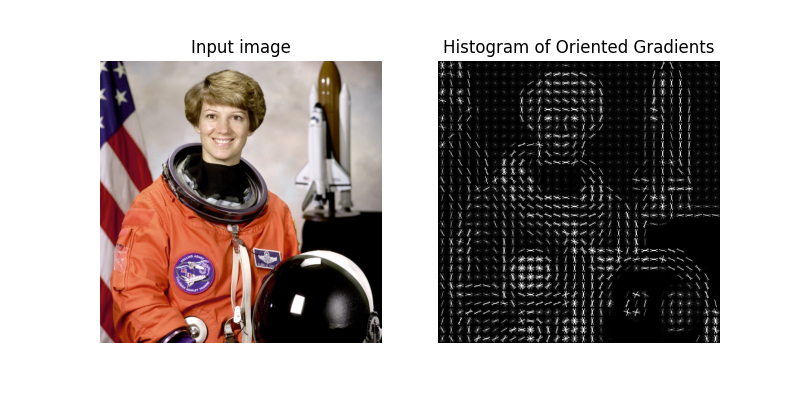

SVM은 선형 분류기이다. 한 이미지를 다차원 공간의 한 벡터라고 보면 여러 이미지는 여러 벡터가 된다. 이 여러 벡터를 잘 구분짓는 방법이다. 여기서는 얼굴이냐 아니냐를 구분하는 것이 중요하다.

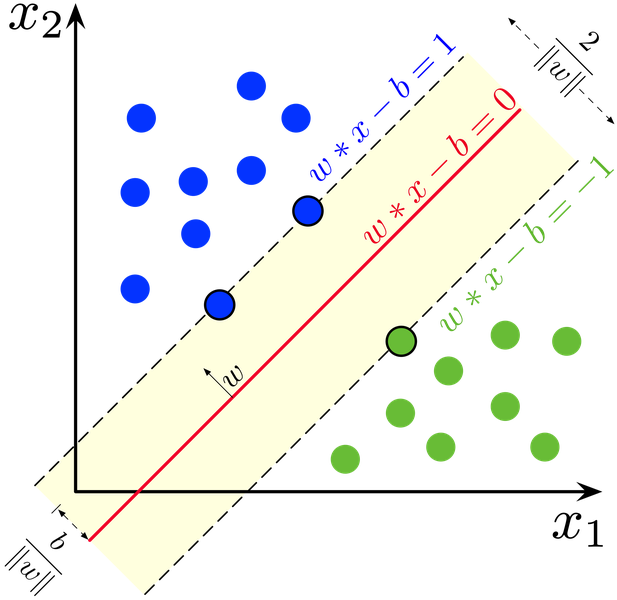

이미지의 색상만 가지고는 SVM이 큰 힘을 발휘하지 못한다. 하지만 이미지가 HOG를 통해 벡터로 만들어진다면 SVM이 잘 작동한다.

그렇다면 얼굴의 위치는 어떻게 찾을 수 있을까? 바로 sliding window를 사용한다. sliding window는 작은 영역(window)을 이동해가며 확인하는 방법을 말한다. 큰 이미지의 작은 영역을 잘라 얼굴이 있는 지 확인하고, 다시 작은 영역을 옆으로 옮겨 얼굴이 있는 지 확인하는 방식이다. 물론 이렇게 한다면 이미지가 크면 클수록 오래걸리는 단점이 있다. 바로 이 지점이 딥러닝이 필요해지는 이유다.

그럼 dlib을 활용해 hog detector를 선언해 보자.

In [29]:
# detector를 선언합니다

detector_hog = dlib.get_frontal_face_detector()
print("🌫🛸")

🌫🛸


detector_hog를 이용해서 얼굴의 bounding box를 추출한다.

In [30]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("🌫🛸")

🌫🛸


dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor()를 이용햐서 opencv의 bgr 이미지를 rgb로 변환해 주었다.

detector_hog의 두번째 파라미터는 이미지 피라미드의 수이다. 이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 한다. 이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능하다.

rectangles[[(345, 98) (531, 284)]]


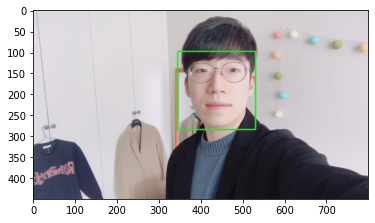

In [31]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

dlib detector는 dlib.rectangles 타입의 객체를 반환한다. dlib.rectangles는 dlib.rectangle 객체의 배열 형태로 이루어져 있다.

dlib.rectangle 객체는 left(), top(), right(), bottom(), height(), width() 등의 멤버 함수를 포함하고 있다.

### 얼굴 랜드마크 face landmark

스티커를 섬세하게 적용하기 위해서는 이목구비의 위치를 아는 것이 매우 중요하다. 

이목구비의 위치를 추론하는 것을 face landmark localization 기술이라고 한다. face landmark는 detection의 결과물인 bounding box로 잘라낸(crop)얼굴 이미지를 이용한다.

**Object keypoint estimation 알고리즘**

Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 한다. keypoint를 찾는 알고리즘은 크게 2가지로 나뉜다.



1. top-down : bounding box를 찾고 box 내부의 keypoint를 예측

2. bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

이번 예제에서는 1번 방식을 다룬다.

**Dlib landmark localization**

잘라진 얼굴 이미지에서 아래 68개의 이목구비 위치를 찾는다.

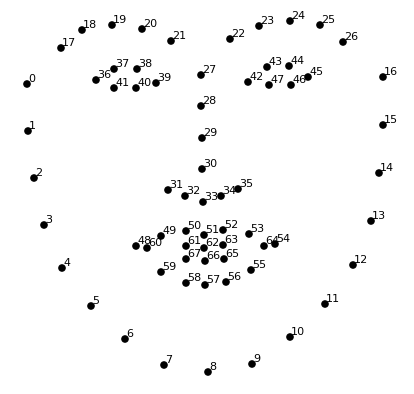

이 때 점의 개수는 데이터셋과 논문마다 다르다. 예를 들면, AFLW 데이터셋은 21개를 사용하고 ibug3 데이터셋은 68개를 사용한다.

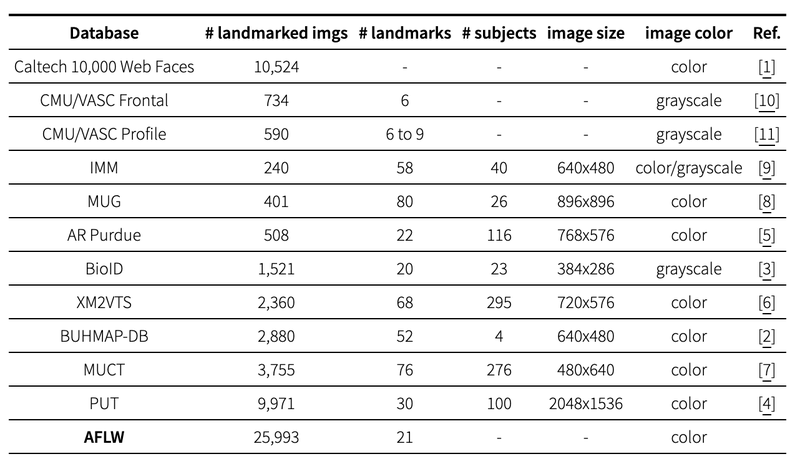

Dlib은 ibug 300-W 데이터셋으로 학습한 pretrained model 을 제공한다. 학습 알고리즘은 regression tree의 앙상블 모델을 사용한다.

Dlib의 제공되는 모델을 사용해보겠다.

In [32]:
# 모델 불러오기

model_path = "/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat"
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


landmark_predictor는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection을 반환한다.

In [33]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아낸다

for dlib_rect in dlib_rects:
  points = landmark_predictor(img_rgb, dlib_rect)
  # face landmark 좌표를 저장해둔다.
  list_points = list(map(lambda p: (p.x, p.y), points.parts()))
  list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


points 는 dlib.full_object_detection 의 객체이기 때문에 parts() 함수로 개별 위치에 접근할 수 있다. 조금 더 직관적인 (x, y) 형태로 접근할 수 있도록 변환해 주었다. 따라서 list_points 는 tuple (x, y) 68개로 이루어진 리스트가 됩니다. 이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장됩니다.

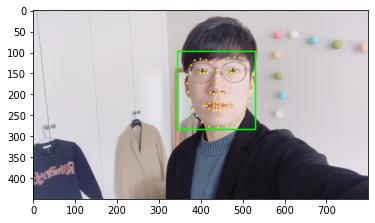

In [34]:
# 랜드마크를 영상에 출력

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### 스티커 적용하기

이제 왕관 스티커를 머리에 씌울 준비가 되었다.

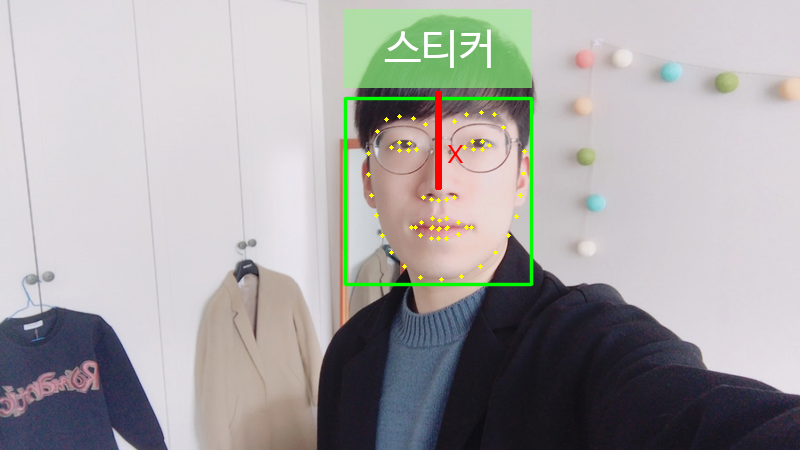

랜드마크를 기준으로 '눈썹 위 얼굴 중앙'에 스티커를 씌우면 될 것 같다. 구현 방법은 여러 가지가 있다. 위 그림처럼 코 중심을 기준으로 높이 x 이상에 그려도 되고 눈썹 위 n 픽셀 위에 스티커를 구현해도 된다.

중요한 것은 얼굴 위치, 카메라의 거리에 따라 픽셀 x가 다르기 때문에 비율로 계산을 해줘야 한다. 계산할 수치는 두가지이다.

1. 스티커 위치

x
=
x
n
o
s
e

y
=
y
n
o
s
e
−
h
e
i
g
h
t/
2


2. 스티커 크기

width = height = widthbbox

In [35]:
# 좌표 확인

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(437, 182)
(x,y) : (437,89)
(w,h) : (187,187)


얼굴 이미지에서 코의 중심점이 (437, 182)로 나온다.

준비해 둔 스티커 이미지를 읽어서 적용해 보겠다.

In [37]:
sticker_path = '/content/drive/MyDrive/crown_data/king.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(187, 187, 3)


왕관 이미지를 읽고 윗 단계에서 계산한 크기로 resize 한다.

원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정한다. 이미지 시작점은 top-left 좌표이기 때문이다.

In [38]:
refined_x = x - w // 2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (344,-98)


y축 좌표의 값이 음수로 되어있다...

음수는 무슨 의미일까?

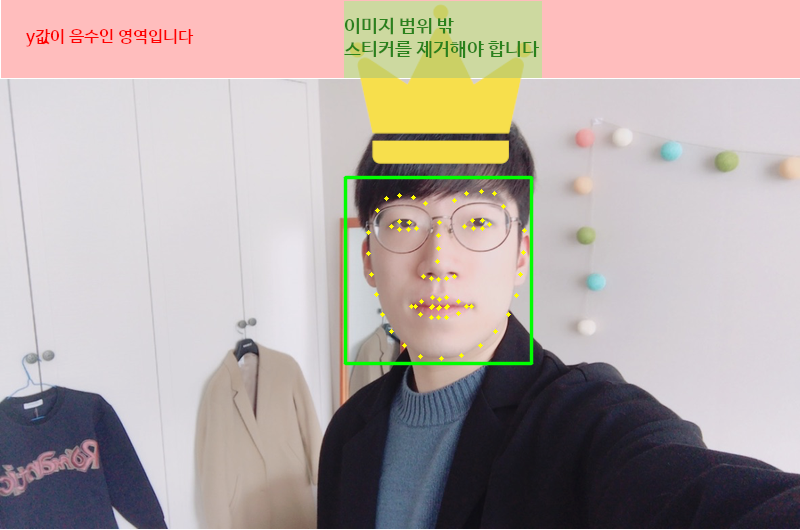

스티커의 시작점이 얼굴 사진의 영역을 벗어나면 음수로 표현된다. 그런데 opencv 데이터는 numpy ndarray 형태의 데이터를 사용한다. ndarray는 음수 인덱스에 접근할 수 없기 때문에 음수에 대한 예외 처리를 해줘야 한다. 따라서 그림에서 보는 것처럼 이미지의 범위를 벗어난 스티커 부분을 제거해 줘야 한다.

위의 경우는 y축 좌표의 값만 음수로 나왔지만 x축 좌표의 값도 음수로 나올 수도 있다.

사실 스티커가 원본 이미지의 범위를 넘어가는 경우는 하나 더 있다. 바로 스티커의 시작점 + 스티커 사진의 크기가 원본 이미지의 크기보다 큰 경우이다. 스티커 사진의 오른쪽이나 아래쪽으로 넘어가는 경우다. 이 경우는 어떻게 처리해야 할까?

In [39]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (344,0)


-y 크기만큼 스티커를 crop하고, top의 x 좌표와 y 좌표를 각각의 경우에 맞춰 원본 이미지의 경계 값으로 수정하면 위와 같은 형식이 나온다.

In [41]:
# 원본 이미지에 스티커를 적용

#길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
print("슝~")

슝~


sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지이다. 예제에서는 (344,0) 부터 (344+187, 0+89) 범위의 이미지를 의미한다.

스티커 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용한다. 따라서 np.where를 통해 img_sticker가 0인 부분은 sticker_area를 사용하고 0이 아닌 부분을 img_sticker를 사용하면 된다. img_show에 다시 적용해 보자

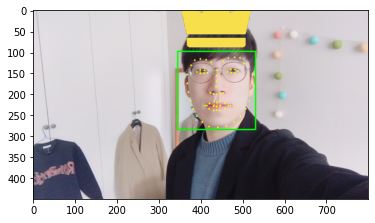

In [42]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

스티커 기본 기능이 완성되었다.

bounding box와 landmark를 제거하고 최종 결과만 출력해 보자. img_show 대신, 지금까지 아껴 두었떤 img_bar를 활용할 것이다.

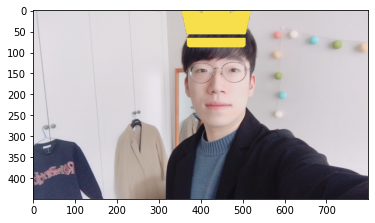

In [43]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()